In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as explot

import seaborn as sns
sns.set()
import copy
import warnings
import itertools
from scipy import linalg
import matplotlib as mpl

from sklearn import mixture
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import accuracy_score
from scipy.stats import boxcox, probplot, norm
from scipy.stats import mode, multivariate_normal

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## EDA

**Seeds Dataset**
1. area A,
2. perimeter P,
3. compactness $C = \frac{4*\pi*A}{P^2}$,
4. length of kernel,
5. width of kernel,
6. asymmetry coefficient
7. length of kernel groove.

In [3]:
#import dataset
df = pd.read_csv('/content/drive/MyDrive/118B/seeds.csv', header= None)

#name columns
df.columns = ['area','perimeter','compactness','length','width','asymmetry','groove','group']

#saving group id variable for later
groups = df['group']
df.drop('group', axis = 1, inplace = True)

df.head()

,area,perimeter,compactness,length,width,asymmetry,groove
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175


**Clean Data**

In [4]:
#check data types
df.dtypes

area           float64
perimeter      float64
compactness    float64
length         float64
width          float64
asymmetry      float64
groove         float64
dtype: object

In [5]:
#drop nan or blanks if any
df.isnull().values.any()

False

In [6]:
#mean, sd, n, 
mean = np.mean(df,axis = 0)
sd = np.std(df,axis = 0)

print('n =',df.shape[0])
df.describe().T.drop(['count'],axis = 1) #not sure which ones to drop

n = 210


,mean,std,min,25%,50%,75%,max
area,14.847524,2.909699,10.5900,12.27000,14.35500,17.305000,21.1800
perimeter,14.559286,1.305959,12.4100,13.45000,14.32000,15.715000,17.2500
compactness,0.870999,0.023629,0.8081,0.85690,0.87345,0.887775,0.9183
length,5.628533,0.443063,4.8990,5.26225,5.52350,5.979750,6.6750
width,3.258605,0.377714,2.6300,2.94400,3.23700,3.561750,4.0330
asymmetry,3.700201,1.503557,0.7651,2.56150,3.59900,4.768750,8.4560
groove,5.408071,0.491480,4.5190,5.04500,5.22300,5.877000,6.5500


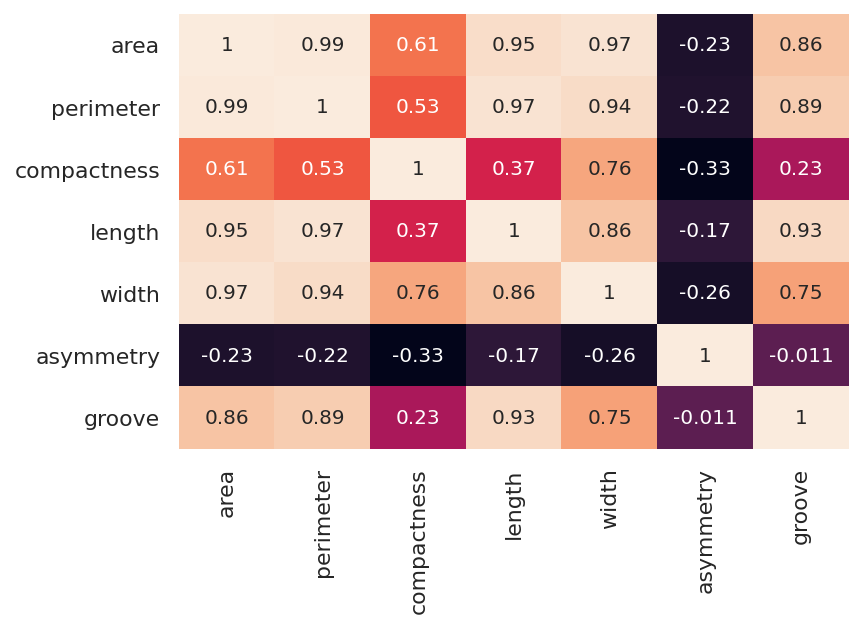

In [7]:
sns.heatmap(df.corr(), annot=True, cbar=False);

In [8]:
# drop some of columns that are highly dependant 
# (like 'area' and 'perimeter')
df = df.drop(columns=['perimeter'])

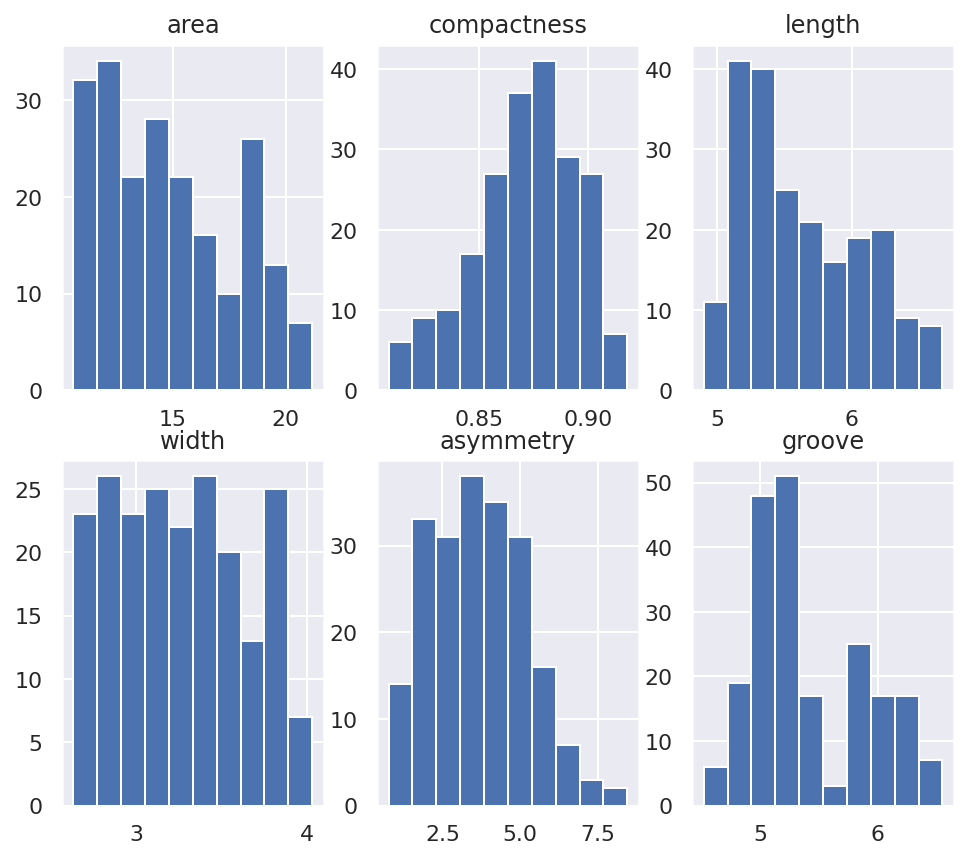

In [9]:
plt.rcParams['figure.figsize'] = [8,7] 
fig, axs = plt.subplots(2, 3)
index = 0

# loop through number of subplots
for i in range(2):
  for j in range(3):
    axs[i,j].hist(df.iloc[:,index])
    axs[i,j].set_title(df.columns[index])
    index += 1

In [10]:
# transform data and apply StandardScaler

df_box = PowerTransformer(method='box-cox').fit_transform(df)
df_std = StandardScaler().fit_transform(df_box)

df_norm = pd.DataFrame(df_std, columns=df.columns)


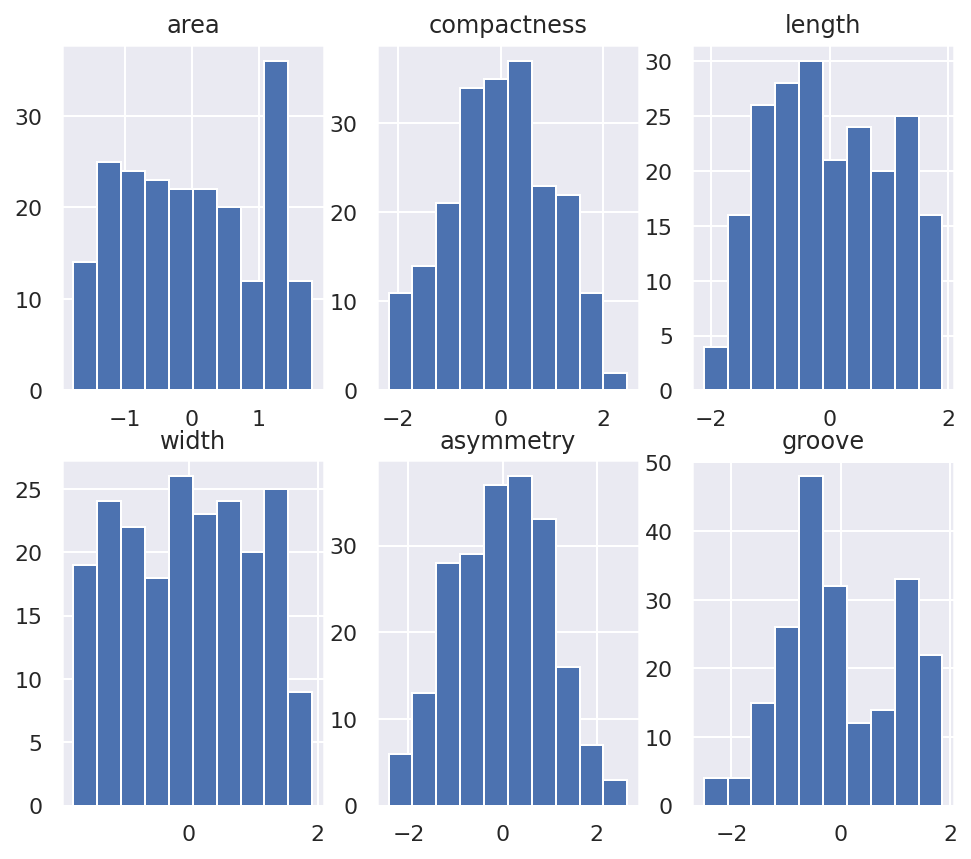

In [11]:
plt.rcParams['figure.figsize'] = [8,7] 
fig, axs = plt.subplots(2, 3)
index = 0

# loop through number of subplots
for i in range(2):
  for j in range(3):
    axs[i,j].hist(df_norm.iloc[:,index])
    axs[i,j].set_title(df_norm.columns[index])
    index += 1

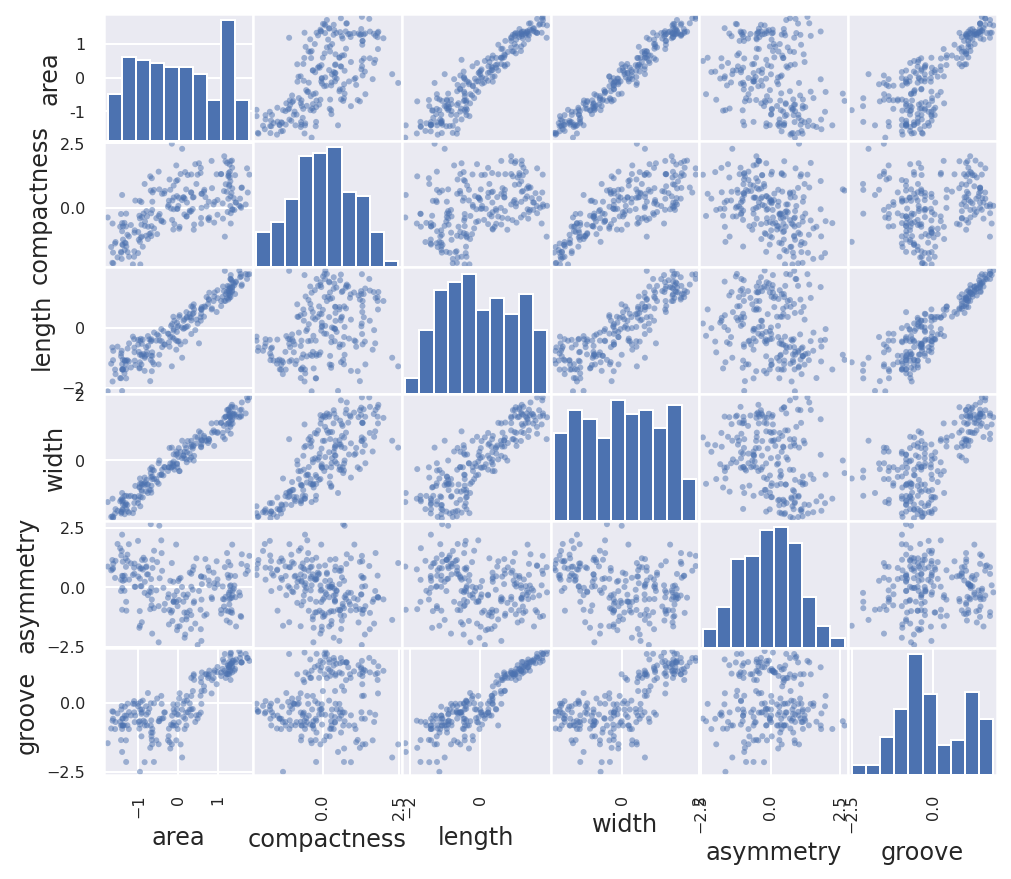

In [12]:
# scatter matrix
pd.plotting.scatter_matrix(df_norm)
plt.show()

## PCA

In [13]:
def PCA(X, num_components):

  #Calculate the matrix of mean subtracted data points
  Z = X - np.mean(X, axis = 0)

  #Calculate the covariance matrix of the mean subtracted data points
  cov = np.cov(Z, rowvar = False)

  #Find the eigenvalues and eigenvectors of the covariance matrix
  eigen_values, eigen_vectors = np.linalg.eigh(cov)

  #Sort the eigenvalues and eigenvectors in descending order
  sorted_index = np.argsort(eigen_values)[::-1]
  sorted_eigenvalues = eigen_values[sorted_index]
  sorted_eigenvectors = eigen_vectors[:, sorted_index]

  #Create a subset from the ordered Eigenvalue matrix using the first n_components eigenvectors
  new_eigenvectors = sorted_eigenvectors[:, 0 : num_components]

  #Transform the data from higher dimension to lower dimension
  X_reduced = np.dot(new_eigenvectors.transpose(), Z.transpose()).transpose()

  return X_reduced, sorted_eigenvalues

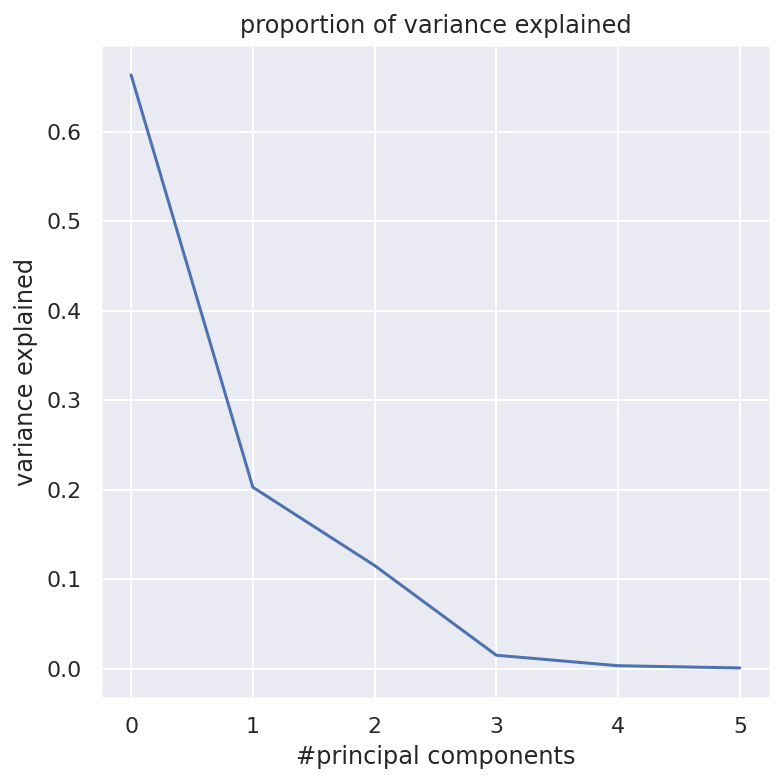

In [14]:
# Find percentage of variance explained by principal component
vals = PCA(df_norm,7)[1] #7 doesnt matter here since we only want the eigenvalues
var_explained = vals/np.sum(vals) #standardize eigenvalues

# plot
plt.rcParams['figure.figsize'] = [6,6]
plt.plot(var_explained)
plt.title('proportion of variance explained')
plt.xlabel('#principal components')
plt.ylabel('variance explained')
plt.show()

#looks at the elbow is at 2 principal components

In [15]:
# create dataframes with 2 and 3 principle components 
PC2 = PCA(df_norm, 2)[0]
df_2comp = pd.DataFrame(PC2, columns = ['PC1', 'PC2'])

PC3 = PCA(df_norm, 3)[0]
df_3comp = pd.DataFrame(PC3, columns = ['PC1', 'PC2', 'PC3'])

Will probabily run kmeans and mog with 2 or 3 principal components

In [16]:
class KMeansClusters:
    
    def __init__(self, X, k, max_iters=100):
        self.X = X
        self.k = k
        self.max_iters = max_iters
        
        self.dim = X.shape[1]
        self.N = X.shape[0]
        
        centroid_indices = np.random.RandomState(2).permutation(X.shape[0])[:k]
        self.centroids = X[centroid_indices]
        
        self.clusters = self.get_clusters(self.X, self.centroids)
    
    def get_clusters(self, X, centroids):
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)
    
    def plot_data_2d(self, labels):
        sns.scatterplot(self.X[:,0], self.X[:,1], hue=labels, palette="deep")
        plt.title('Prediction using comp1, comp2')
        plt.show()

    def plot_data_3d(self, labels):
        first = self.X[:,0]
        second = self.X[:,1]
        third = self.X[:,2]
        lab = {'x': 'Comp 1', 'y':'Comp2', 'z': 'Comp3'}
        title_s = 'Prediction using 3 components'
        fig = explot.scatter_3d(x=first, y = second, z = third,labels=lab, 
                                title=title_s, color = labels, 
                                width=800, height=600)
        fig.show()

    def fit(self, plot=None):
        iters = 0
        while True:
            # get new labels 
            labels = self.get_clusters(self.X, self.centroids)
            
            # copy of last centeroids for comparison
            copy_center = copy.deepcopy(self.centroids)
            
            # update the centeroids from new labels
            self.centroids = np.array([self.X[labels==k].mean(axis=0) 
                                            for k in range(self.k)])

            # check if centeroids are same
            if np.array_equal(copy_center, self.centroids):
                break
            
            if iters == self.max_iters:
                break
            iters += 1
        self.clusters = self.get_clusters(self.X, self.centroids)
        
        if(plot == "3d"):
            self.plot_data_3d(self.clusters)
        if(plot == "2d"):
            self.plot_data_2d(self.clusters)

        return self
    
    def fit_predict(self,real_labels=None):
        if (real_labels is not None):
            self.fit()
            new_labels = np.zeros_like(self.clusters)
            for i in range(self.k):
                mask = (self.clusters == i)
                new_labels[mask] = mode(real_labels[mask])[0]
            return new_labels
        else: 
            self.fit()
            return self.clusters

In [17]:
df_3comp_np = df_3comp.to_numpy()
model = KMeansClusters(X = df_3comp_np, k=3)
pred = model.fit_predict(real_labels = groups)

In [18]:
print("Accuracy of KMeans with 3 PC: ", accuracy_score(groups, pred))


Accuracy of KMeans with 3 PC:  0.919047619047619


In [19]:
model.fit(plot='3d')

In [20]:
first = df_3comp_np[:,0]
second = df_3comp_np[:,1]
third = df_3comp_np[:,2]
lab = {'x': 'Comp 1', 'y':'Comp2', 'z': 'Comp3'}
title_s = 'Real target values colored by groups column'
fig = explot.scatter_3d(x=first, y = second, z = third,labels=lab, 
                        title=title_s, color = groups, 
                        width=800, height=600)
fig.show()        

In [21]:
df_2comp_np = df_2comp.to_numpy()
model2d = KMeansClusters(X = df_2comp_np, k=3)
pred2d = model2d.fit_predict(real_labels = groups)

In [22]:
print("Accuracy of KMeans with 2 PC: ", accuracy_score(groups, pred2d))

Accuracy of KMeans with 2 PC:  0.9


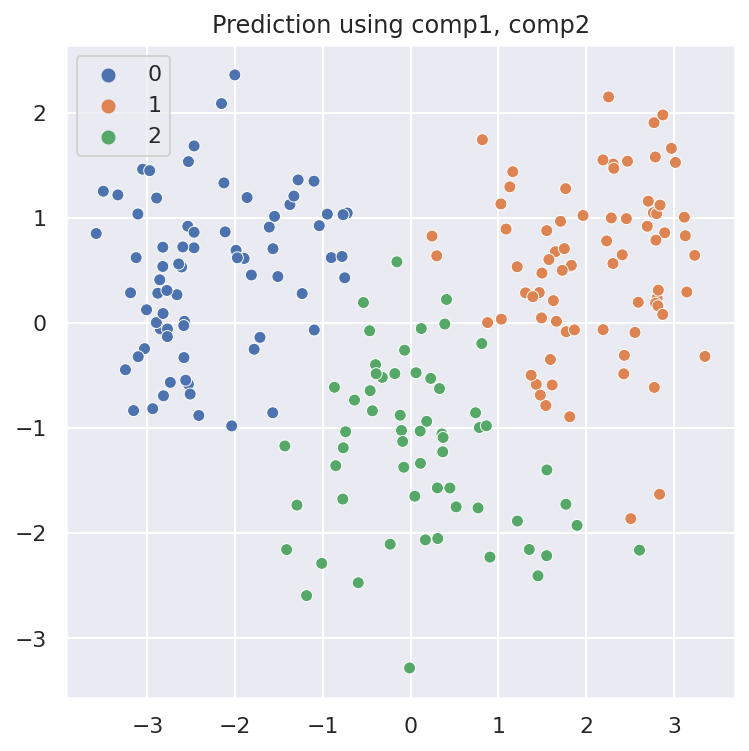

In [23]:
model2d.fit(plot='2d')

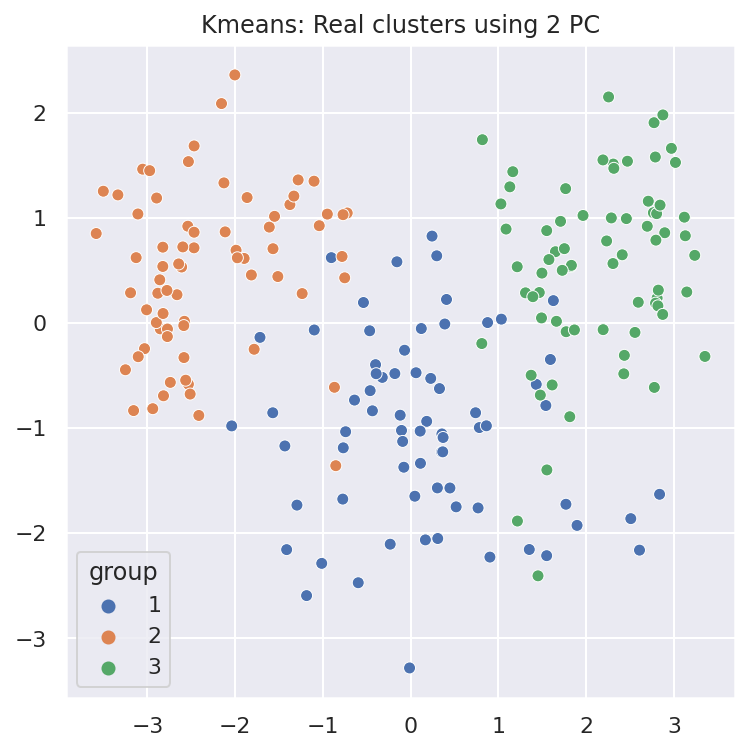

In [24]:
# actual target values
sns.scatterplot(df_2comp_np[:,0], df_2comp_np[:,1], hue=groups, palette="deep")
plt.title("Kmeans: Real clusters using 2 PC")
plt.show()

In [25]:
# The skeleton for this class was given to us in COGS188, but I have coded 
# the E-step, M-step, and others. 

class MoG_EM:
    def __init__(self, X, k, max_iters=100):
        self.X = X
        self.k = k
        self.max_iters = max_iters        
        
        self.dim = self.X.shape[1] 
        self.N = self.X.shape[0] 
    
        # initialize mu using kmeans algorithm
        model_KM = KMeansClusters(self.X, self.k)
        self.mu = model_KM.fit().centroids

        self.clusters = model_KM.clusters
        
        self.pi = np.ones(self.k) / self.k
        
        
        self.sigma = np.zeros((self.k, self.dim, self.dim))
        for i in range(self.k):
            np.fill_diagonal(self.sigma[i], 5.0)
        
        if (self.dim == 2):
            x,y = np.meshgrid(np.sort(self.X[:,0]),np.sort(self.X[:,1]))
            self.XY = np.array([x.flatten(),y.flatten()]).T
        elif (self.dim == 3):
            x,y = np.meshgrid(np.sort(self.X[:,0]),np.sort(self.X[:,1]))
            self.XY = np.array([x.flatten(),y.flatten()]).T
        
        # dealing with covariance matrix being positive semidefinite
        self.sigma_correction = 0.0 * np.identity(self.dim)     

    def plot_2d(self, colors=None):
        sns.scatterplot(self.X[:,0], self.X[:,1], hue=colors, palette="deep")
        
        for m,c in zip(self.mu,self.sigma):
            c += self.sigma_correction
            multi_normal = multivariate_normal(mean=m,cov=c)
            plt.contour(np.sort(self.X[:,0]),np.sort(self.X[:,1]),
                        multi_normal.pdf(self.XY).reshape(len(self.X),len(self.X)),
                        colors='black',alpha=0.3)
            plt.scatter(m[0],m[1],c='grey',zorder=10,s=100)
        plt.title('Using comp1, comp2')
        plt.show()
    
    def expectation(self):
        r = np.zeros((self.N, self.k))
        
        for pi, mu, sig, c in zip(self.pi, self.mu, self.sigma, range(self.k)):
            sig += self.sigma_correction
            normal = multivariate_normal(mu, sig).pdf(self.X)
            # numerator of r_ic
            numer = pi * normal
            
            # calculate denominator
            c_all = []
            for pi2, mu2, sig2 in zip(self.pi, self.mu, self.sigma):
                normal2 = pi2 * multivariate_normal(mu2, sig2).pdf(self.X)
                c_all.append(normal2)
            # sum over all clusters
            denom = np.sum(c_all, axis=0)
            r[:, c] = numer / denom
            
        return r
    
    def maximization(self, r):
        self.mu = []
        self.sigma = []
        self.pi = []
        
        N = np.sum(r)
        
        for c in range(self.k):
            N_c = np.sum(r[:, c], axis=0)
            
            self.pi.append(N_c / N)
            
            r_x_sum = np.sum(self.X * r[:, c].reshape(len(self.X), 1), axis=0)
            mu = r_x_sum / N_c
            self.mu.append(mu)
            
            r_c = np.array(r[:, c]).reshape(len(self.X), 1)
            X_minus_mu = self.X - mu
            sig = np.dot((r_c * X_minus_mu).T, X_minus_mu)
            self.sigma.append(sig / N_c)
    
    def fit(self, plot=None):
        r = None
        for it in range(self.max_iters):
            r = self.expectation()
            self.maximization(r)

        self.clusters = np.argmax(r, axis=1)
        
        if (plot=='2d'):
            self.plot_2d(self.clusters)
        elif (plot=='3d'):
            print("3D plotting not implemented.")
    
    def fit_predict(self,real_labels=None):
        if (real_labels is not None):
            self.fit()
            new_labels = np.zeros_like(self.clusters)
            for i in range(self.k):
                mask = (self.clusters == i)
                new_labels[mask] = mode(real_labels[mask])[0]
            return new_labels
        else: 
            self.fit()
            return self.clusters

In [26]:
df_3comp_np = df_3comp.to_numpy()
mog = MoG_EM(df_3comp_np, k=3, max_iters=100)

In [27]:
pred_mog_3d = mog.fit_predict(real_labels=groups)

In [28]:
print("Accuracy of MoG with 3 PC: ", accuracy_score(groups, pred_mog_3d))

Accuracy of MoG with 3 PC:  0.861904761904762


In [29]:
from sklearn.mixture import GaussianMixture as GMM

In [30]:
# compare with Sklearn GaussianMixture
gmm_3d = GMM(n_components=3)
gmm_3d.fit(df_3comp_np)
pred_gmm_3d = gmm_3d.predict(df_3comp_np)


In [31]:
# format prediction like targets (groups column)
pred_gmm_3d_new = np.zeros_like(pred_gmm_3d)
for i in range(3):
    mask = (pred_gmm_3d == i)
    pred_gmm_3d_new[mask] = mode(groups[mask])[0]

In [32]:
print("Accuracy using Sklearn GaussianMixture with 3 PC: ", accuracy_score(groups, pred_gmm_3d_new))

Accuracy using Sklearn GaussianMixture with 3 PC:  0.919047619047619


In [33]:
df_2comp_np = df_2comp.to_numpy()
model2d_mog = MoG_EM(X = df_2comp_np, k=3)
pred_mog_2d = model2d_mog.fit_predict(real_labels = groups)

In [34]:
print("Accuracy of MoG with 2 PC: ", accuracy_score(groups, pred_mog_2d))

Accuracy of MoG with 2 PC:  0.8047619047619048


In [35]:
# compare with Sklearn GaussianMixture
gmm_2d = GMM(n_components=3)
gmm_2d.fit(df_2comp_np)
pred_gmm_2d = gmm_2d.predict(df_2comp_np)


In [36]:
# format prediction like targets (groups column)
pred_gmm_2d_new = np.zeros_like(pred_gmm_2d)
for i in range(3):
    mask = (pred_gmm_2d == i)
    pred_gmm_2d_new[mask] = mode(groups[mask])[0]

In [37]:
print("Accuracy using Sklearn GaussianMixture with 2 PC: ", accuracy_score(groups, pred_gmm_2d_new))

Accuracy using Sklearn GaussianMixture with 2 PC:  0.919047619047619


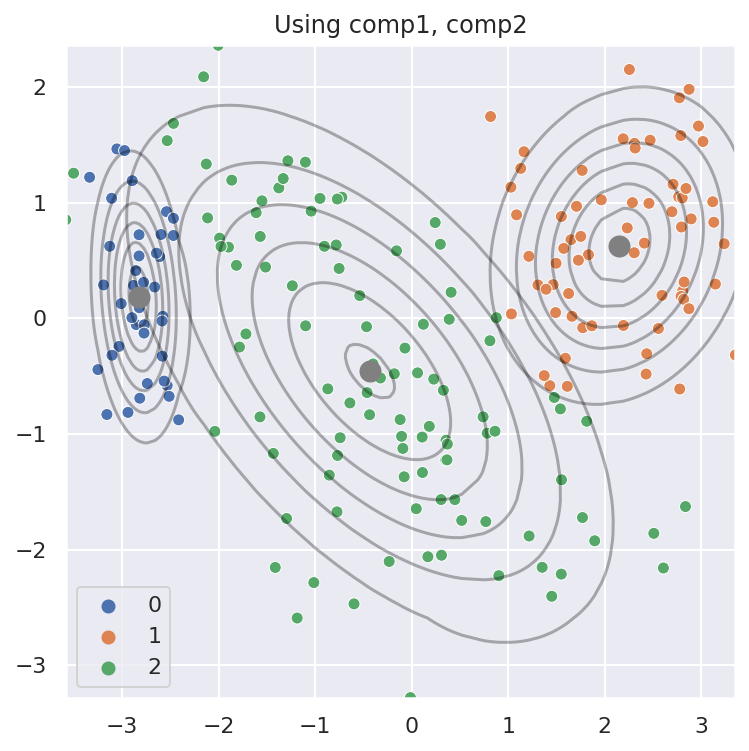

In [38]:
model2d_mog.fit(plot='2d')

In [200]:
color_iter = itertools.cycle(['navy', 'darkorange', 'green'])

# Source:
# https://scikit-learn.org/stable/auto_examples/mixture \
# /plot_gmm.html#sphx-glr-auto-examples-mixture-plot-gmm-py

def plot_results(X, Y_, means, covariances, index, title):
    f = plt.figure()
    f.set_figheight(11)
    f.set_figwidth(5)
    splot = f.add_subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 5, marker='o',color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.2)
        splot.add_artist(ell)

    plt.title(title)
    plt.show()

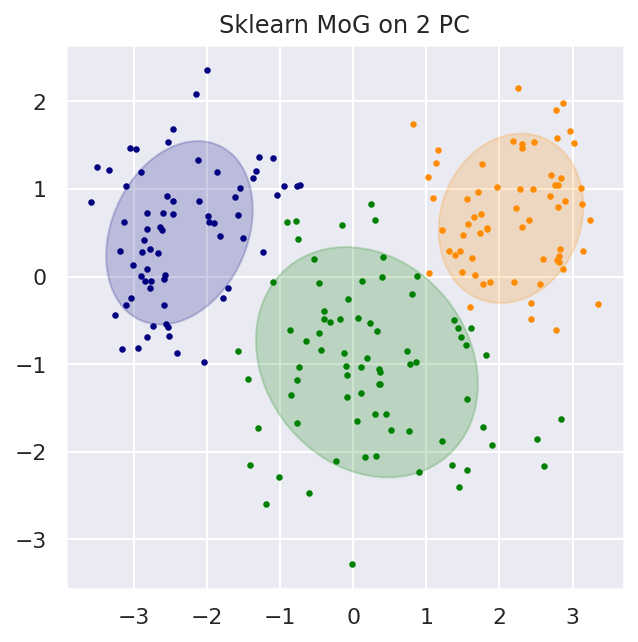

In [201]:
# Fit a Gaussian mixture with EM using 3 clusters
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full').fit(df_2comp_np)
plot_results(df_2comp_np, gmm.predict(df_2comp_np), gmm.means_, gmm.covariances_, 0,
             'Sklearn MoG on 2 PC')